In [1]:
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import sklearn.cluster as cluster
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import xarray as xr
from metpy.units import units
import metpy.calc as mpcalc

plt.style.use('fivethirtyeight')

In [2]:
np.random.seed(123)

In [3]:
'''
Define Model Parameters
'''
MODEL_DATE = '20240811'
MODEL_CYCLE = '06z'

LAT = 32.77
LON = -96

FORECAST_DATES = [(datetime.today() + timedelta(days=day)).strftime('%Y-%m-%d') 
                  for day in range(1, 16)]

In [4]:
base_url = f'https://nomads.ncep.noaa.gov/dods/gefs/gefs{MODEL_DATE}/gefs_pgrb2ap5_all_{MODEL_CYCLE}'

ds = xr.open_dataset(base_url, decode_times=True)

/Users/rhawthorne/miniconda3/envs/metpy_env/lib/python3.12/site-packages/xarray/coding/times.py:172: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


In [5]:
t_max = ds.tmax2m.metpy.sel(lat=LAT, lon=360+LON, method='nearest') * units('K')

In [6]:
t_max = t_max.metpy.convert_units('degF')
t_max

Magnitude,[[nan 75.93722534179688 92.81765747070312 ... 98.24303436279297 100.28704071044922 95.80204010009766] [nan 75.82999420166016 86.28079223632812 ... 101.13310241699219 99.72366333007812 97.14693450927734] [nan 75.85394287109375 95.97991180419922 ... 96.52999114990234 102.90684509277344 100.16838836669922] ... [nan 76.40963745117188 91.03913879394531 ... 100.43140411376953 105.01012420654297 94.78069305419922] [nan 74.50076293945312 93.88245391845703 ... 100.4609603881836 102.25585174560547 98.16437530517578] [nan 76.01006317138672 92.48152923583984 ... 97.14451599121094 99.95811462402344 96.66781616210938]]
Units,degree_Fahrenheit


In [7]:
df = t_max.to_dataframe('temp')
df.dropna(inplace=True)
df.reset_index(inplace=True)
df

,ens,time,lat,lon,temp
0,1.0,2024-08-11 12:00:00,33.0,264.0,75.937225
1,1.0,2024-08-11 18:00:00,33.0,264.0,92.817657
2,1.0,2024-08-12 00:00:00,33.0,264.0,97.556061
3,1.0,2024-08-12 06:00:00,33.0,264.0,94.085480
4,1.0,2024-08-12 12:00:00,33.0,264.0,80.325378
...,...,...,...,...,...
1979,31.0,2024-08-26 06:00:00,33.0,264.0,98.220787
1980,31.0,2024-08-26 12:00:00,33.0,264.0,86.520294
1981,31.0,2024-08-26 18:00:00,33.0,264.0,97.144516
1982,31.0,2024-08-27 00:00:00,33.0,264.0,99.958115


In [8]:
# Only include rows with 00 UTC
# High temps usually occur in the 6 hours prior over the Americas
df = df[df['time'].dt.strftime('%H:%M:%S').str.contains('00:00:00')]

In [9]:
df.reset_index(drop=True, inplace=True)
df

,ens,time,lat,lon,temp
0,1.0,2024-08-12,33.0,264.0,97.556061
1,1.0,2024-08-13,33.0,264.0,102.294632
2,1.0,2024-08-14,33.0,264.0,103.081749
3,1.0,2024-08-15,33.0,264.0,103.511528
4,1.0,2024-08-16,33.0,264.0,102.824059
...,...,...,...,...,...
491,31.0,2024-08-23,33.0,264.0,108.655495
492,31.0,2024-08-24,33.0,264.0,104.494530
493,31.0,2024-08-25,33.0,264.0,104.983917
494,31.0,2024-08-26,33.0,264.0,101.072563


In [10]:
df_time = df.groupby(['time'])
#last_forecast_date = df_time.get_group(FORECAST_DATES[-1],)[['temp']]
last_forecast_date = df_time.get_group((FORECAST_DATES[-1],))[['temp']]

In [11]:
def elbow_method(dataset, min_clusters, max_clusters):
    """
    Perform the elbow method to determine the optimal number of clusters using k-means.

    Args:
    - dataset: The input dataset for clustering.
    - min_clusters: The minimum number of clusters to consider.
    - max_clusters: The maximum number of clusters to consider.

    Returns:
    - The optimal number of clusters based on the elbow method.
    """
    distortions = []
    K = range(min_clusters, max_clusters + 1)

    for k in K:
        kmeans = cluster.KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans.fit(dataset)
        distortions.append(kmeans.inertia_)

    # Plotting the elbow curve
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Distortion')
    plt.title('Elbow Method')
    plt.show()

    # Calculate the differences between successive distortions
    differences = np.diff(distortions)

    # Calculate the second derivative of differences
    second_derivatives = np.diff(differences)

    # Find the index of the elbow point (maximum second derivative)
    elbow_index = np.argmax(second_derivatives) + 1

    # Determine the optimal number of clusters
    optimal_clusters = min_clusters + elbow_index

    return optimal_clusters

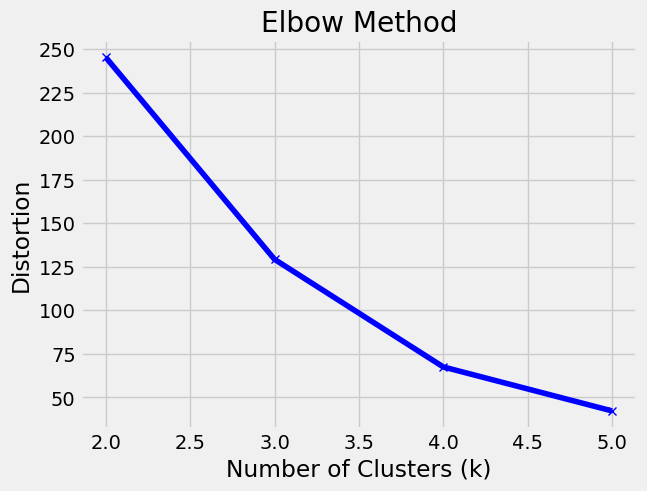

3


In [12]:
elbow_scr = elbow_method(last_forecast_date, 2, 5)
print(elbow_scr)

In [13]:
def silhouette_score_method(dataset, min_clusters, max_clusters):
    """
    Perform the silhouette score method to determine the optimal number of clusters using k-means.

    Args:
    - dataset: The input dataset for clustering.
    - min_clusters: The minimum number of clusters to consider.
    - max_clusters: The maximum number of clusters to consider.

    Returns:
    - The optimal number of clusters based on the silhouette score.
    """
    silhouette_scores = []
    K = range(min_clusters, max_clusters + 1)

    # keep reproducibility there
    np.random.seed(42)

    for k in K:
        kmeans = cluster.KMeans(n_clusters=k, random_state=0, n_init='auto')
        kmeans.fit(dataset)
        labels = kmeans.predict(dataset)
        score = silhouette_score(dataset, labels)
        silhouette_scores.append(score)

    # Plotting the silhouette scores
    plt.plot(K, silhouette_scores, 'bx-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score Method')
    plt.show()

    # Find the index of the maximum silhouette score
    optimal_index = np.argmax(silhouette_scores)

    # Determine the optimal number of clusters
    optimal_clusters = min_clusters + optimal_index

    return optimal_clusters

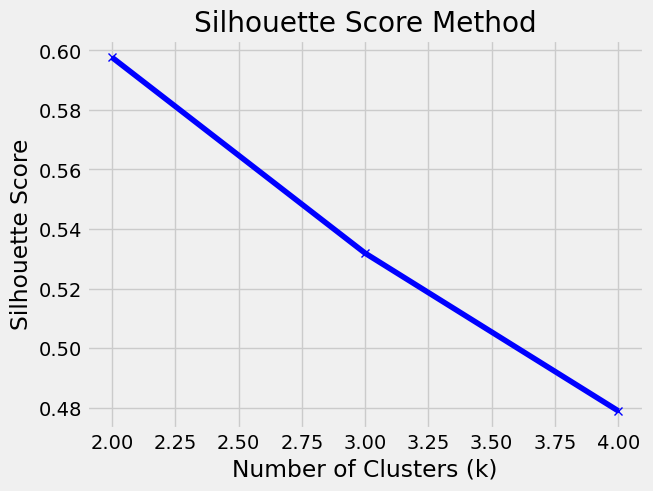

2


In [14]:
silhouette_scr = silhouette_score_method(last_forecast_date, 2, 4)
print(silhouette_scr)

In [15]:
# Either elbow_scr or silhouette_scr
number_clusters = elbow_scr

In [16]:
cluster_centers_dict = {}

for date in FORECAST_DATES:
    single_forecast_date = df_time.get_group((date,))
    p25 = single_forecast_date['temp'].quantile(.25)
    p50 = single_forecast_date['temp'].median()
    p75 = single_forecast_date['temp'].quantile(.75)
    kmeans = cluster.KMeans(init='k-means++', n_clusters=number_clusters, n_init='auto')
    kmeans = kmeans.fit(single_forecast_date[['temp']])
    cluster_centers = kmeans.cluster_centers_.flatten()
    cluster_centers = np.append(cluster_centers, [p25, p50, p75])
    # Add the cluster centers to the dictionary with the date as the key
    cluster_centers_dict[date] = cluster_centers

# Create a DataFrame from the dictionary
df_cluster_centers = pd.DataFrame.from_dict(cluster_centers_dict, orient='index')
df_cluster_centers = df_cluster_centers.rename_axis('date').reset_index()

# Rename last few columns to add p25, p50, p75
col_names = list(df_cluster_centers.columns)
p25_column = int(col_names[-3])
p50_column = int(col_names[-2])
p75_column = int(col_names[-1])
df_cluster_centers.rename(columns={p25_column: 'p25', p50_column: 'p50', p75_column: 'p75'}, 
                          inplace=True)

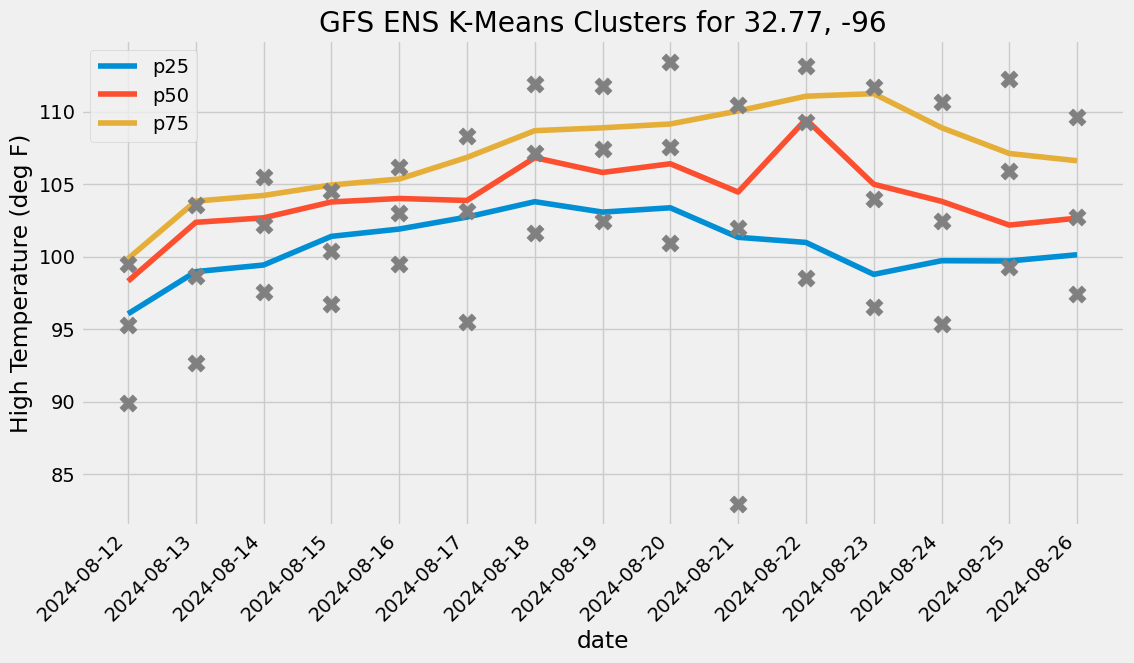

In [19]:
for n in range(0, number_clusters):
    ax = df_cluster_centers.plot.scatter(x='date', y=n, color='gray', ax=plt.gca(),
                                         marker='X', s=150, figsize=(12, 6), zorder=10,
                                         title=f'GFS ENS K-Means Clusters for {LAT}, {LON}')
df_cluster_centers.plot.line(y='p25', ax=plt.gca())
df_cluster_centers.plot.line(y='p50', ax=plt.gca())
df_cluster_centers.plot.line(y='p75', ax=plt.gca())
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
ax.set_ylabel('High Temperature (deg F)')
plt.show()